# Home Credit Default Risk -  EDA and ML

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns


pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
import os


In [2]:
import sklearn
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import  SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import imblearn

from imblearn.over_sampling import RandomOverSampler

In [3]:
def reduce_mem_usage(df, verbose=True):  #reduce memory usage
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
#Load train data
train_data = reduce_mem_usage(pd.read_csv('application_train.csv'))

#Load test data
test_data = reduce_mem_usage(pd.read_csv('application_test.csv'))


Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%


# Exploration data

Overview dataframe

In [5]:
print('Training data shape: ', train_data.shape)
train_data.head() #Overview train data

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,

In [6]:
print('Test data shape: ', test_data.shape)
test_data.head() #Overview test data

Test data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018845,-19241,-2329,-5168.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752441,0.789551,0.159546,0.065979,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.050507,NaN,NaN,0.067200,0.061188,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.052612,NaN,NaN,0.066589,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.051392,NaN,NaN,NaN,block of flats,0.039215,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035797,-18064,-4469,-9120.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564941,0.291748,0.432861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019104,-20038,-4458,-2176.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699707,0.610840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secon

In [7]:
train_data.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

# Visualize train data

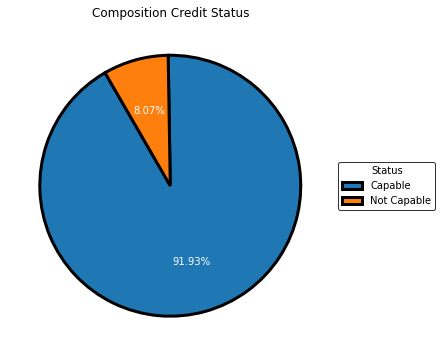

In [8]:
# Get the value counts for the 'TARGET' variable
y_value_counts = train_data['TARGET'].value_counts()

# Set up the pie chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

# Define the labels and data for the pie chart
data = [y_value_counts[0], y_value_counts[1]]

# Create the pie chart
pie_1 = ax.pie(data, explode=(0, 0), textprops=dict(size=10, color="white"),
                autopct="%.2f%%", startangle=120, wedgeprops=dict(edgecolor="black", linewidth=3))

# Set title and legend
labels = "Capable", "Not Capable"
plt.title('Composition Credit Status')
plt.legend(labels, title="Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), edgecolor="black")


Distribution train dataset

In [9]:
# Visualizes the distribution of data using a stacked bar plot
def stack_plot(data, xtick, col2='TARGET', col3='total'):
    ind = np.arange(data.shape[0])

    # Dynamically determines the size of the plot based on the number of unique values in the specified column
    if len(data[xtick].unique()) < 5:
        plt.figure(figsize=(5, 5))
    elif len(data[xtick].unique()) >= 5 and len(data[xtick].unique()) < 10:
        plt.figure(figsize=(7, 7))
    else:
        plt.figure(figsize=(10, 10))

    # Creates a bar plot using the data provided
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Loans')

    # Configures the x-axis ticks and labels based on the unique values in the specified column
    plt.xticks(ticks=ind, rotation=90, labels=list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('Capable', 'Not Capable'))

    # Displays the plot
    plt.show()

In [10]:
# Generates bar plots for grouped data, displaying loan distribution
def barplots(data, col1, col2='TARGET', top=False):
    # Groups the data by the specified column and calculates counts and averages
    temp = pd.DataFrame(train_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    temp['total'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']

    # Calls the stack_plot function with the grouped and aggregated data
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    
    # Prints the DataFrame
    print(temp)


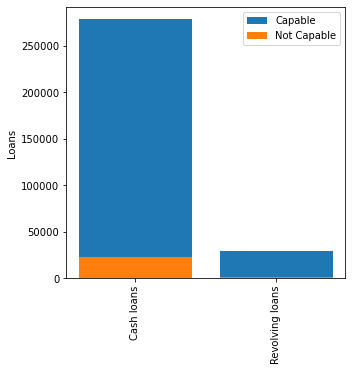

  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783


In [11]:
barplots(train_data, 'NAME_CONTRACT_TYPE', 'TARGET')


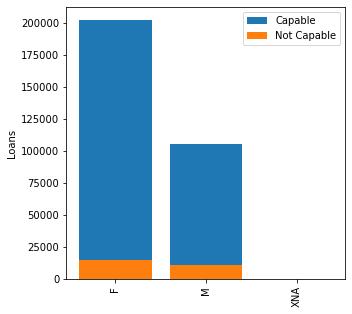

  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000


In [12]:
barplots(train_data, 'CODE_GENDER', 'TARGET')


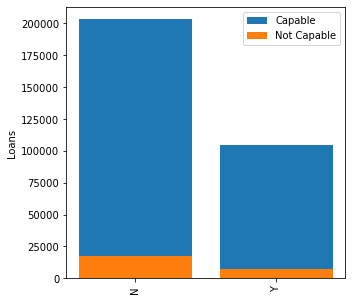

  FLAG_OWN_CAR  TARGET   total       Avg
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437


In [13]:
barplots(train_data, 'FLAG_OWN_CAR', 'TARGET')

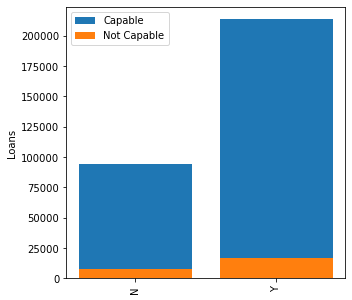

  FLAG_OWN_REALTY  TARGET   total       Avg
0               N    7842   94199  0.083249
1               Y   16983  213312  0.079616


In [14]:
barplots(train_data, 'FLAG_OWN_REALTY', 'TARGET')

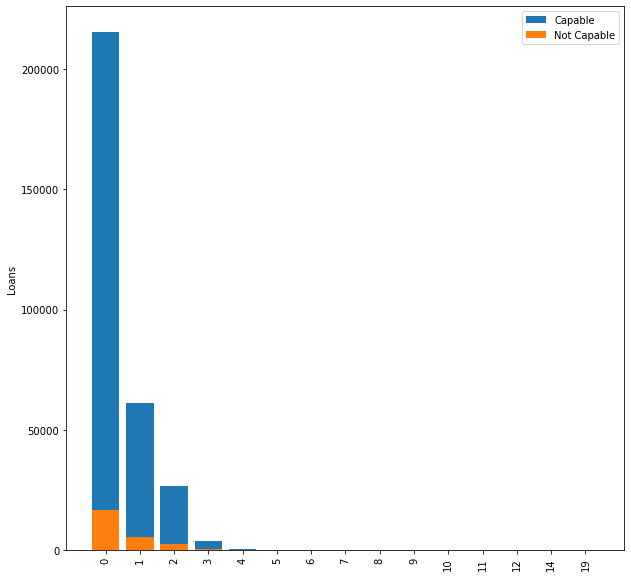

    CNT_CHILDREN  TARGET   total       Avg
0              0   16609  215371  0.077118
1              1    5454   61119  0.089236
2              2    2333   26749  0.087218
3              3     358    3717  0.096314
4              4      55     429  0.128205
5              5       7      84  0.083333
6              6       6      21  0.285714
7              7       0       7  0.000000
8              8       0       2  0.000000
9              9       2       2  1.000000
10            10       0       2  0.000000
11            11       1       1  1.000000
12            12       0       2  0.000000
13            14       0       3  0.000000
14            19       0       2  0.000000


In [15]:
barplots(train_data, 'CNT_CHILDREN', 'TARGET')

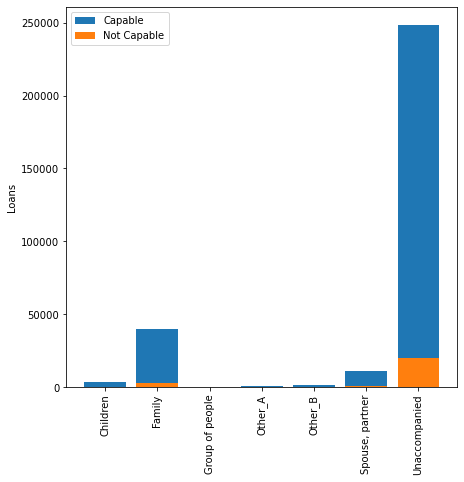

   NAME_TYPE_SUITE  TARGET   total       Avg
0         Children     241    3267  0.073768
1           Family    3009   40149  0.074946
2  Group of people      23     271  0.084871
3          Other_A      76     866  0.087760
4          Other_B     174    1770  0.098305
5  Spouse, partner     895   11370  0.078716
6    Unaccompanied   20337  248526  0.081830


In [16]:
barplots(train_data, 'NAME_TYPE_SUITE', 'TARGET')

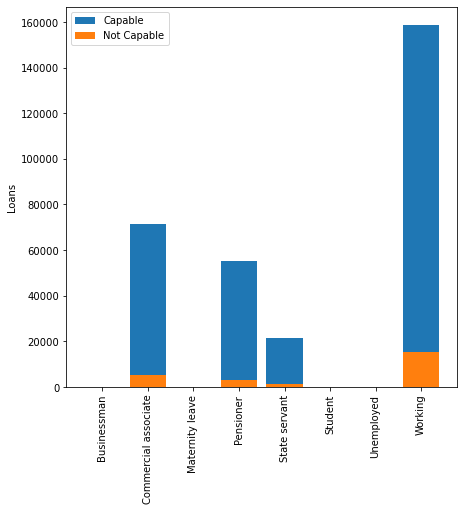

       NAME_INCOME_TYPE  TARGET   total       Avg
0           Businessman       0      10  0.000000
1  Commercial associate    5360   71617  0.074843
2       Maternity leave       2       5  0.400000
3             Pensioner    2982   55362  0.053864
4         State servant    1249   21703  0.057550
5               Student       0      18  0.000000
6            Unemployed       8      22  0.363636
7               Working   15224  158774  0.095885


In [17]:
barplots(train_data, 'NAME_INCOME_TYPE', 'TARGET')

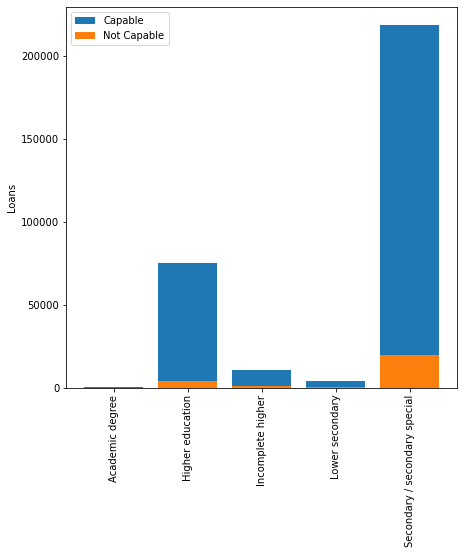

             NAME_EDUCATION_TYPE  TARGET   total       Avg
0                Academic degree       3     164  0.018293
1               Higher education    4009   74863  0.053551
2              Incomplete higher     872   10277  0.084850
3                Lower secondary     417    3816  0.109277
4  Secondary / secondary special   19524  218391  0.089399


In [18]:
barplots(train_data, 'NAME_EDUCATION_TYPE', 'TARGET')


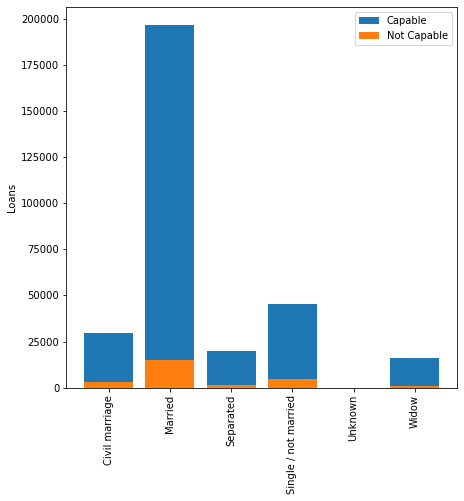

     NAME_FAMILY_STATUS  TARGET   total       Avg
0        Civil marriage    2961   29775  0.099446
1               Married   14850  196432  0.075599
2             Separated    1620   19770  0.081942
3  Single / not married    4457   45444  0.098077
4               Unknown       0       2  0.000000
5                 Widow     937   16088  0.058242


In [19]:
barplots(train_data, 'NAME_FAMILY_STATUS', 'TARGET')

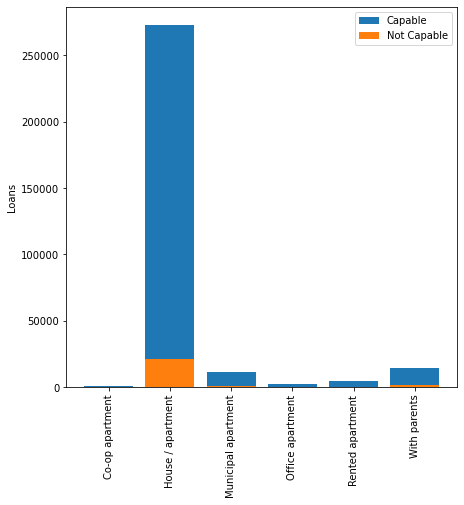

     NAME_HOUSING_TYPE  TARGET   total       Avg
0      Co-op apartment      89    1122  0.079323
1    House / apartment   21272  272868  0.077957
2  Municipal apartment     955   11183  0.085397
3     Office apartment     172    2617  0.065724
4     Rented apartment     601    4881  0.123131
5         With parents    1736   14840  0.116981


In [20]:
barplots(train_data, 'NAME_HOUSING_TYPE', 'TARGET')

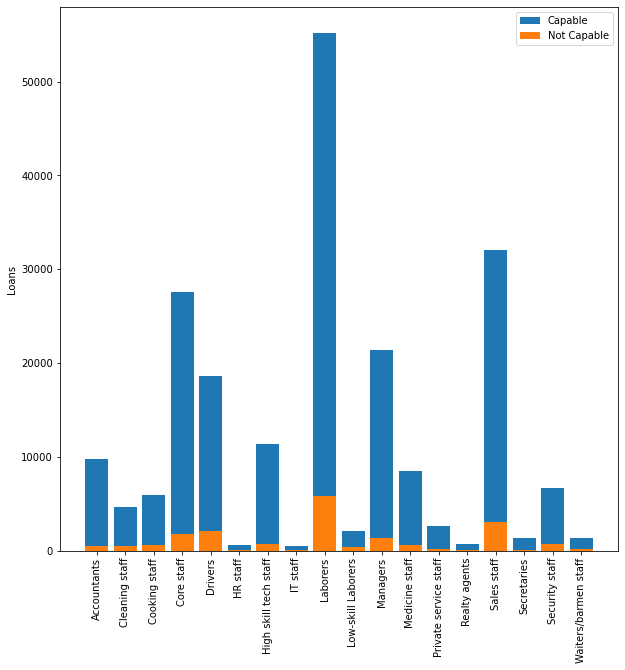

          OCCUPATION_TYPE  TARGET  total       Avg
0             Accountants     474   9813  0.048303
1          Cleaning staff     447   4653  0.096067
2           Cooking staff     621   5946  0.104440
3              Core staff    1738  27570  0.063040
4                 Drivers    2107  18603  0.113261
5                HR staff      36    563  0.063943
6   High skill tech staff     701  11380  0.061599
7                IT staff      34    526  0.064639
8                Laborers    5838  55186  0.105788
9      Low-skill Laborers     359   2093  0.171524
10               Managers    1328  21371  0.062140
11         Medicine staff     572   8537  0.067002
12  Private service staff     175   2652  0.065988
13          Realty agents      59    751  0.078562
14            Sales staff    3092  32102  0.096318
15            Secretaries      92   1305  0.070498
16         Security staff     722   6721  0.107424
17   Waiters/barmen staff     152   1348  0.112760


In [21]:
barplots(train_data, 'OCCUPATION_TYPE', 'TARGET', False)

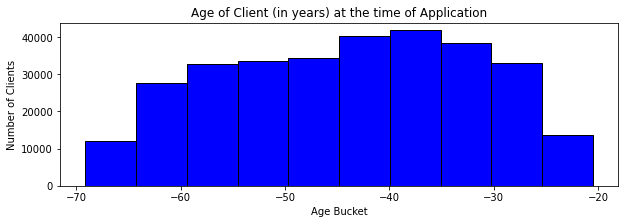

In [22]:
# Set the figure size
plt.figure(figsize=(10, 3))

# Create a histogram of the 'DAYS_BIRTH' variable
plt.hist(train_data['DAYS_BIRTH'].values / 365, bins=10, edgecolor='black', color='blue')

# Set the title and labels
plt.title('Age of Client (in years) at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')

# Display the histogram
plt.show()


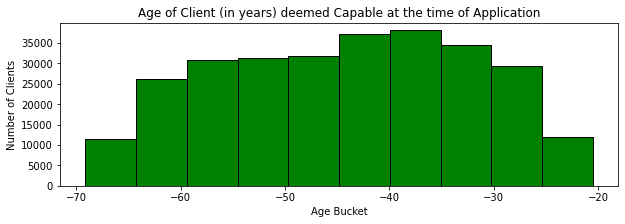

In [23]:
# Extract ages for clients deemed Capable
capable_days_birth = train_data[train_data['TARGET'] == 0]['DAYS_BIRTH'].values / 365

# Set the figure size
plt.figure(figsize=(10, 3))

# Create a histogram for Capable clients
plt.hist(capable_days_birth, bins=10, edgecolor='black', color='green')

# Set the title and labels
plt.title('Age of Client (in years) deemed Capable at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')

# Display the histogram
plt.show()


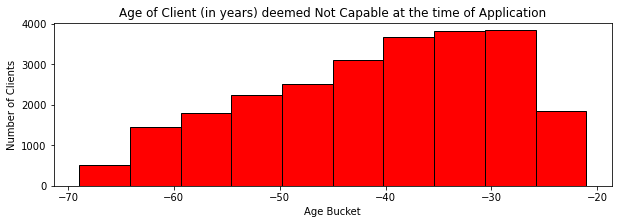

In [24]:
# Extract ages for clients deemed Not Capable
not_capable_days_birth = train_data[train_data['TARGET'] == 1]['DAYS_BIRTH'].values / 365

# Set the figure size
plt.figure(figsize=(10, 3))

# Create a histogram for Not Capable clients
plt.hist(not_capable_days_birth, bins=10, edgecolor='black', color='red')

# Set the title and labels
plt.title('Age of Client (in years) deemed Not Capable at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')

# Display the histogram
plt.show()


# Data preparation

In [25]:
print('Number of duplicates train data : ',train_data.duplicated().sum()) # checking duplicated data
print('Number of duplicates test data : ',train_data.duplicated().sum())

Number of duplicates train data :  0
Number of duplicates test data :  0


In [26]:
pd.set_option('display.max_rows', None)
missing_data = train_data.isnull().sum(axis=0)
missing_data = missing_data[missing_data>0]
missing_data

AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
OWN_CAR_AGE                     202929
OCCUPATION_TYPE                  96391
CNT_FAM_MEMBERS                      2
EXT_SOURCE_1                    173378
EXT_SOURCE_2                       660
EXT_SOURCE_3                     60965
APARTMENTS_AVG                  156061
BASEMENTAREA_AVG                179943
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BUILD_AVG                 204488
COMMONAREA_AVG                  214865
ELEVATORS_AVG                   163891
ENTRANCES_AVG                   154828
FLOORSMAX_AVG                   153020
FLOORSMIN_AVG                   208642
LANDAREA_AVG                    182590
LIVINGAPARTMENTS_AVG            210199
LIVINGAREA_AVG                  154350
NONLIVINGAPARTMENTS_AVG         213514
NONLIVINGAREA_AVG               169682
APARTMENTS_MODE                 156061
BASEMENTAREA_MODE               179943
YEARS_BEGINEXPLUATATION_M

In [27]:
#handling missing data
train_data['NAME_FAMILY_STATUS'].fillna('Data_Not_Available', inplace=True)
train_data['NAME_HOUSING_TYPE'].fillna('Data_Not_Available', inplace=True)
train_data.replace(max(train_data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

train_data['AMT_ANNUITY'].fillna(0, inplace=True)
#A total of 12 datapoints are there where Annuity Amount is null.

train_data['AMT_GOODS_PRICE'].fillna(0, inplace=True)
#A total of 278 datapoints are there where Annuity Amount is null.

train_data['NAME_TYPE_SUITE'].fillna('Data_Not_Available', inplace=True)
#Removing datapoints where 'Name_Type_Suite' is null.

train_data['NAME_FAMILY_STATUS'].replace('Unknown','Married', inplace=True)
#Removing datapoints where 'Name_Family_Status' is Unknown.

train_data['OCCUPATION_TYPE'].fillna(train_data['OCCUPATION_TYPE'].mode(), inplace=True)
train_data['FLAG_MOBIL'].fillna('Data_Not_Available', inplace=True)
train_data['FLAG_EMP_PHONE'].fillna('Data_Not_Available', inplace=True)
train_data['FLAG_CONT_MOBILE'].fillna('Data_Not_Available', inplace=True)
train_data['FLAG_EMAIL'].fillna('Data_Not_Available', inplace=True)

train_data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)

#Replace NA with 0 for Count of Client Family Members
train_data['CNT_FAM_MEMBERS'].fillna(0,inplace=True)

train_data['EXT_SOURCE_1'].fillna(0, inplace=True)
train_data['EXT_SOURCE_2'].fillna(0, inplace=True)
train_data['EXT_SOURCE_3'].fillna(0, inplace=True)
train_data['SK_ID_CURR'].fillna(0,inplace=True)

In [28]:
pd.set_option('display.max_rows', None)
missing_data = train_data.isnull().sum(axis=0)
missing_data = missing_data[missing_data>0]
missing_data

DAYS_EMPLOYED                    55374
OWN_CAR_AGE                     202929
APARTMENTS_AVG                  156061
BASEMENTAREA_AVG                179943
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BUILD_AVG                 204488
COMMONAREA_AVG                  214865
ELEVATORS_AVG                   163891
ENTRANCES_AVG                   154828
FLOORSMAX_AVG                   153020
FLOORSMIN_AVG                   208642
LANDAREA_AVG                    182590
LIVINGAPARTMENTS_AVG            210199
LIVINGAREA_AVG                  154350
NONLIVINGAPARTMENTS_AVG         213514
NONLIVINGAREA_AVG               169682
APARTMENTS_MODE                 156061
BASEMENTAREA_MODE               179943
YEARS_BEGINEXPLUATATION_MODE    150007
YEARS_BUILD_MODE                204488
COMMONAREA_MODE                 214865
ELEVATORS_MODE                  163891
ENTRANCES_MODE                  154828
FLOORSMAX_MODE                  153020
FLOORSMIN_MODE                  208642
LANDAREA_MODE            

In [29]:
df = train_data.dropna(axis=1)

In [30]:
missing_data = df.isnull().sum(axis=0)
missing_data = missing_data[missing_data>0]
missing_data

Series([], dtype: int64)

In [31]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002.0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003.0,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004.0,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-4260.0,-2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.000000,0.556152,0.729492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006.0,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008018,-19005,-9832.0,-2437,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.000000,0.650391,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007.0,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028656,-19932,-4312.0,-3458,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.000000,0.322754,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       

# Correlation

In [33]:
df= train_data.loc[:,['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY','NAME_TYPE_SUITE','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
       'CNT_FAM_MEMBERS','DAYS_BIRTH', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE','FLAG_EMP_PHONE', 'DAYS_REGISTRATION',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE']]

In [34]:
df_correlation=df.corr(method='pearson').TARGET.sort_index().reset_index()

In [35]:
print('Most positive correlation')
df_correlationhead=df_correlation.sort_values(by='TARGET',ascending=False).iloc[1:10]
df_correlationhead

Most positive correlation


,index,TARGET
5,DAYS_BIRTH,0.078239
12,REG_CITY_NOT_WORK_CITY,0.050994
8,FLAG_EMP_PHONE,0.045982
6,DAYS_REGISTRATION,0.041975
11,LIVE_CITY_NOT_WORK_CITY,0.032518
10,FLAG_WORK_PHONE,0.028524
3,CNT_CHILDREN,0.019187
4,CNT_FAM_MEMBERS,0.009312
7,FLAG_CONT_MOBILE,0.000370


In [36]:
print('Most negative correlation')
df_correlationtail=df_correlation.sort_values(by='TARGET',ascending=False).tail(10)
df_correlationtail

Most negative correlation


,index,TARGET
6,DAYS_REGISTRATION,0.041975
11,LIVE_CITY_NOT_WORK_CITY,0.032518
10,FLAG_WORK_PHONE,0.028524
3,CNT_CHILDREN,0.019187
4,CNT_FAM_MEMBERS,0.009312
7,FLAG_CONT_MOBILE,0.000370
2,AMT_INCOME_TOTAL,-0.003982
0,AMT_ANNUITY,-0.012794
9,FLAG_PHONE,-0.023806
1,AMT_CREDIT,-0.030369


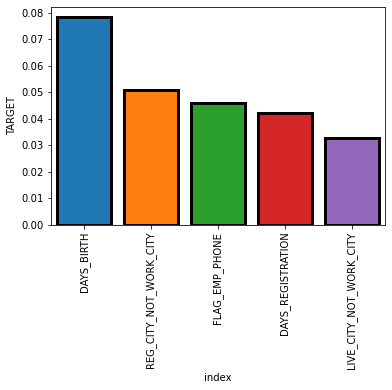

In [37]:
chart = sns.barplot(data=df_correlationhead.head(),x="index",y="TARGET",saturation=1, edgecolor = "#000000", linewidth = 3)

for item in chart.get_xticklabels():
  item.set_rotation(90)

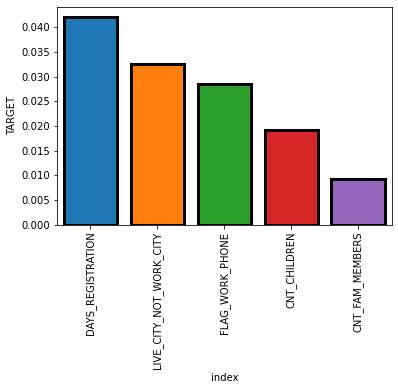

In [38]:
chart = sns.barplot(data=df_correlationtail.head(),x="index",y="TARGET",saturation=1, edgecolor = "#000000", linewidth = 3)

for item in chart.get_xticklabels():
  item.set_rotation(90)

Text(0.5, 1.0, '\nHeatmap for top 10 most positive correlation\n')

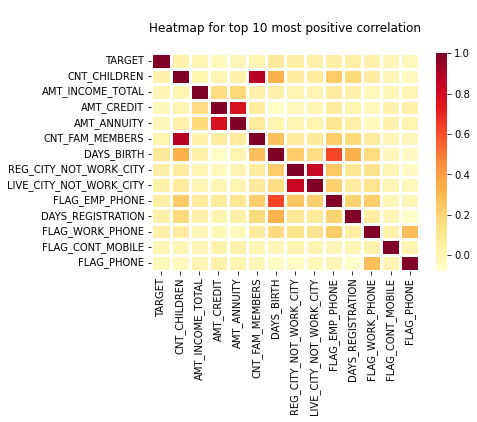

In [39]:
sns.heatmap(df.corr(),cmap="YlOrRd", edgecolor = "#1c1c1c", linewidth = 3)
plt.title(f'\nHeatmap for top 10 most positive correlation\n')

In [40]:
catcol = [col for col in df.columns if df[col].dtype == "object"] #encoding data
le = LabelEncoder()
label_mapping = {}
for col in catcol:
        df[col] = le.fit_transform(df[col])
        label_mapping[col] = dict(zip(le.classes_, le.transform(le.classes_)))

label_mapping

{'NAME_CONTRACT_TYPE': {'Cash loans': 0, 'Revolving loans': 1},
 'CODE_GENDER': {'F': 0, 'M': 1, 'XNA': 2},
 'FLAG_OWN_CAR': {'N': 0, 'Y': 1},
 'FLAG_OWN_REALTY': {'N': 0, 'Y': 1},
 'NAME_TYPE_SUITE': {'Children': 0,
  'Data_Not_Available': 1,
  'Family': 2,
  'Group of people': 3,
  'Other_A': 4,
  'Other_B': 5,
  'Spouse, partner': 6,
  'Unaccompanied': 7},
 'NAME_INCOME_TYPE': {'Businessman': 0,
  'Commercial associate': 1,
  'Maternity leave': 2,
  'Pensioner': 3,
  'State servant': 4,
  'Student': 5,
  'Unemployed': 6,
  'Working': 7},
 'NAME_EDUCATION_TYPE': {'Academic degree': 0,
  'Higher education': 1,
  'Incomplete higher': 2,
  'Lower secondary': 3,
  'Secondary / secondary special': 4},
 'NAME_FAMILY_STATUS': {'Civil marriage': 0,
  'Married': 1,
  'Separated': 2,
  'Single / not married': 3,
  'Widow': 4},
 'NAME_HOUSING_TYPE': {'Co-op apartment': 0,
  'House / apartment': 1,
  'Municipal apartment': 2,
  'Office apartment': 3,
  'Rented apartment': 4,
  'With parents': 5}

# Machine Learning

In [41]:
X=df.drop(['TARGET'],1)
y=df[['TARGET']].values.reshape(-1,1)

# Instantiate RandomOverSampler with a sampling strategy of 0.5 (50% oversampling)
oversample = RandomOverSampler(sampling_strategy=0.5)

# Apply oversampling to the features (X) and target variable (y)
X_over, y_over = oversample.fit_resample(X, y)

In [42]:
train_X,test_X,train_y,test_y = train_test_split(X_over,y_over,test_size=0.2,random_state=0)

XGBboost Classifier

In [43]:
xgboost= XGBClassifier()
xgboost.fit(train_X,train_y)
cv_scores = cross_val_score(xgboost, X_over, y_over, cv=5, scoring='accuracy')  # Using 5-fold cross-validation
print(f'Cross-Validation Scores: {cv_scores}')

Cross-Validation Scores: [0.71733132 0.71562154 0.71657666 0.71533854 0.71970992]


In [44]:
xgboost_pred = xgboost.predict(test_X) # Predictions on the test set

xgboost_conf = confusion_matrix(test_y, xgboost_pred) # Confusion Matrix
xgboost_report = classification_report(test_y, xgboost_pred) # Classification Report
xgboost_acc = round(accuracy_score(test_y, xgboost_pred) * 100, ndigits=3) # Accuracy Score
xgboost_rocauc = roc_auc_score(test_y, xgboost_pred) # ROC AUC Score

# Print Results
print(f"Confusion Matrix : \n\n{xgboost_conf}")
print(f"\nClassification Report : \n\n{xgboost_report}")
print(f"\nThe Accuracy of XGB is {xgboost_acc} %")
print(f'ROC AUC Score with XGBOOST: {xgboost_rocauc}')


Confusion Matrix : 

[[51797  4702]
 [19325  8982]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.73      0.92      0.81     56499
           1       0.66      0.32      0.43     28307

    accuracy                           0.72     84806
   macro avg       0.69      0.62      0.62     84806
weighted avg       0.70      0.72      0.68     84806


The Accuracy of XGB is 71.668 %
ROC AUC Score with XGBOOST: 0.6170419806773128


Confusion Matrix:

A confusion matrix is a table that summarizes the performance of a classification algorithm. It consists of four components:
- True Positive (TP): Instances where the model predicted the positive class correctly.
- True Negative (TN): Instances where the model predicted the negative class correctly.
- False Positive (FP): Instances where the model predicted the positive class incorrectly (actually negative).
- False Negative (FN): Instances where the model predicted the negative class incorrectly (actually positive).

Classification Report:

A classification report provides a summary of various metrics for each class. Common metrics include precision, recall, F1-score, and support.

Precision:
- Precision is the ratio of true positive predictions to the total predicted positives. It measures the accuracy of the positive predictions made by the model.
- Formula: Precision = TP / (TP + FP)
- Interpretation: High precision indicates that when the model predicts the positive class, it is likely to be correct.

Recall (Sensitivity or True Positive Rate):
- Recall is the ratio of true positive predictions to the total actual positives. It measures the model's ability to capture all instances of the positive class.
- Formula: Recall = TP / (TP + FN)
- Interpretation: High recall indicates that the model is effective at identifying most of the positive instances.

F1-Score:
- The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall, making it a useful metric when there is an imbalance between classes.
- Formula: F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
- Interpretation: F1-score ranges from 0 to 1, with higher values indicating a better balance between precision and recall.

Support:
- Support is the number of actual occurrences of the class in the specified dataset. It helps in understanding the distribution of each class in the dataset.
- Interpretation: Higher support values indicate that the class is more prevalent in the dataset.

Accuracy Score:

Accuracy measures the overall correctness of the model's predictions. It is calculated as the ratio of correctly predicted instances to the total instances.

ROC AUC Score:

The Receiver Operating Characteristic Area Under the Curve (ROC AUC) score evaluates the model's ability to distinguish between positive and negative classes across different thresholds.

Decision Tree Classifier

In [45]:
dtr=DecisionTreeClassifier()
dtr.fit(train_X,train_y)
cv_scores = cross_val_score(dtr, X_over, y_over, cv=5,scoring='accuracy')  # Using 5-fold cross-validation
print(f'Cross-Validation Scores: {cv_scores}')

Cross-Validation Scores: [0.92659717 0.92975733 0.93013466 0.92840129 0.92935558]


<AxesSubplot:>

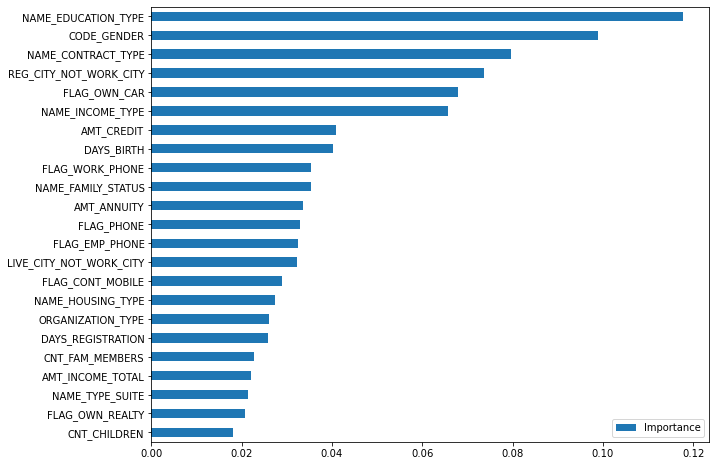

In [46]:
feat_importances = pd.DataFrame(xgboost.feature_importances_, index=test_X.columns, columns=["Importance"]) # Create a DataFrame with feature importances
feat_importances.sort_values(by='Importance', ascending=True, inplace=True)# Sort the DataFrame by Importance in ascending orde

# Plot a horizontal bar chart
feat_importances.plot(kind='barh', figsize=(10, 8))

In [47]:
dtr_pred=dtr.predict(test_X) # Predictions on the test set

dtr_conf=confusion_matrix(test_y,dtr_pred) # Confusion Matrix
dtr_report=classification_report(test_y,dtr_pred) # Classification Report
dtr_acc=round(accuracy_score(test_y,dtr_pred)*100,ndigits=3) # Accuracy Score
dtr_rocauc=roc_auc_score(test_y, dtr_pred) #ROC AUC score

# Print the result
print(f"Confusion Matrix : \n\n{dtr_conf}")
print(f"\nClassification Report : \n\n{dtr_report}")
print(f"\nThe Accuracy of Decision Tree is {dtr_acc} %")
print(f'ROC AUC Score with Decision Tree: {dtr_rocauc}')

Confusion Matrix : 

[[50576  5923]
 [  199 28108]]

Classification Report : 

              precision    recall  f1-score   support

           0       1.00      0.90      0.94     56499
           1       0.83      0.99      0.90     28307

    accuracy                           0.93     84806
   macro avg       0.91      0.94      0.92     84806
weighted avg       0.94      0.93      0.93     84806


The Accuracy of Decision Tree is 92.781 %
ROC AUC Score with Decision Tree: 0.9440681114468579


Gaussian naive bayes classifier

In [48]:
gnb=GaussianNB()
gnb.fit(train_X,train_y)
cv_scores = cross_val_score(gnb, X_over, y_over, cv=3,scoring='accuracy')  # Using 5-fold cross-validation
print(f'Cross-Validation Scores: {cv_scores}')

Cross-Validation Scores: [0.66028739 0.65991949 0.66042889]


In [49]:
gnb_pred=gnb.predict(test_X)# Predictions on the test set

gnb_conf=confusion_matrix(test_y,gnb_pred) #Confusion Matrix
gnb_report=classification_report(test_y,gnb_pred) # Classification Report
gnb_acc=round(accuracy_score(test_y,gnb_pred)*100,ndigits=3) #Accuracy Score
gnb_rocauc=roc_auc_score(test_y, gnb_pred) #ROC AUC Score

# Print the results
print(f"Confusion Matrix : \n\n{gnb_conf}")
print(f"\nClassification Report : \n\n{gnb_report}")
print(f"\nThe Accuracy of Gaussian is {gnb_acc} %")
print(f'ROC AUC Score with Gaussian Naive Bayes: {gnb_rocauc}',)

Confusion Matrix : 

[[55574   925]
 [27892   415]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.67      0.98      0.79     56499
           1       0.31      0.01      0.03     28307

    accuracy                           0.66     84806
   macro avg       0.49      0.50      0.41     84806
weighted avg       0.55      0.66      0.54     84806


The Accuracy of Gaussian is 66.02 %
ROC AUC Score with Gaussian Naive Bayes: 0.4991443567254892


Gradien Boost Classifier

In [50]:
gradien=GradientBoostingClassifier()
gradien.fit(train_X,train_y)
cv_scores = cross_val_score(gradien, X_over, y_over, cv=5,scoring='accuracy')  # Using 5-fold cross-validation
print(f'Cross-Validation Scores: {cv_scores}')

Cross-Validation Scores: [0.68354833 0.68462137 0.68380775 0.68285263 0.68471199]


In [51]:
gradien_pred=gradien.predict(test_X) # Predict on the test dataset

gradien_conf=confusion_matrix(test_y,gradien_pred) #Confusion Matrix
gradien_report=classification_report(test_y,gradien_pred) #Classification Matrix
gradien_acc=round(accuracy_score(test_y,gradien_pred)*100,ndigits=3) # Accuracy Score
gradien_rocauc=roc_auc_score(test_y, gradien_pred) #ROC AUC Score

# Print the results
print(f"Confusion Matrix : \n\n{gradien_conf}")
print(f"\nClassification Report : \n\n{gradien_report}")
print(f"\nThe Accuracy of Gradien Boost is {gradien_acc} %")
print(f'ROC AUC score wiht Gradien Boost: {gradien_rocauc}')

Confusion Matrix : 

[[53349  3150]
 [23717  4590]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.69      0.94      0.80     56499
           1       0.59      0.16      0.25     28307

    accuracy                           0.68     84806
   macro avg       0.64      0.55      0.53     84806
weighted avg       0.66      0.68      0.62     84806


The Accuracy of Gradien Boost is 68.319 %
ROC AUC score wiht Gradien Boost: 0.5531987528005022


Random Forest Classifier

In [52]:
rfc = RandomForestClassifier() 
rfc.fit(train_X,train_y)
cv_scores = cross_val_score(rfc, X_over, y_over, cv=5, scoring='accuracy')  # Using 5-fold cross-validation
print(f'Cross-Validation Scores: {cv_scores}')


Cross-Validation Scores: [0.99541306 0.99905667 0.99913921 0.99919817 0.99909203]


In [53]:
rfc_pred = rfc.predict(test_X) # Predict on the test data set

rfc_conf = confusion_matrix(test_y, rfc_pred) #Confusion Matrix
rfc_report = classification_report(test_y, rfc_pred) # Classification Report
rfc_acc = round(accuracy_score(test_y, rfc_pred)*100, ndigits = 2) # Accuracy Score
rfc_rocauc=roc_auc_score(test_y, rfc_pred) #ROC AUC Score

#Print the results
print(f"Confusion Matrix : \n\n{rfc_conf}")
print(f"\nClassification Report : \n\n{rfc_report}")
print(f"\nThe Accuracy of Random Forest Classifier is {rfc_acc} %")
print(f'ROC AUC score wiht Random Forest: {rfc_rocauc}')

Confusion Matrix : 

[[56425    74]
 [  238 28069]]

Classification Report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56499
           1       1.00      0.99      0.99     28307

    accuracy                           1.00     84806
   macro avg       1.00      1.00      1.00     84806
weighted avg       1.00      1.00      1.00     84806


The Accuracy of Random Forest Classifier is 99.63 %
ROC AUC score wiht Random Forest: 0.9951412139918139


Logistic Regression

In [54]:
lr=LogisticRegression()
lr.fit(train_X,train_y)
cv_scores = cross_val_score(lr, X_over, y_over, cv=5).mean()  # Using 5-fold cross-validation
print(f'Cross-Validation Scores: {cv_scores}')

Cross-Validation Scores: 0.6665581835074869


In [55]:
lr_pred = lr.predict(test_X) #Predict on the test dataset

lr_conf = confusion_matrix(test_y, lr_pred) # Confusion Matrix
lr_report = classification_report(test_y, lr_pred) #Classification Report
lr_acc = round(accuracy_score(test_y, lr_pred)*100, ndigits = 2) #Accuracy Score
lr_rocauc=roc_auc_score(test_y, lr_pred) #ROC AUC Score

#Print the results
print(f"Confusion Matrix : \n\n{lr_conf}")
print(f"\nClassification Report : \n\n{lr_report}")
print(f"\nThe Accuracy of Logistic Reggresion is {lr_acc} %")
print(f'ROC AUC score wiht Logistic Reggresion: {lr_rocauc}')

Confusion Matrix : 

[[56492     7]
 [28305     2]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.67      1.00      0.80     56499
           1       0.22      0.00      0.00     28307

    accuracy                           0.67     84806
   macro avg       0.44      0.50      0.40     84806
weighted avg       0.52      0.67      0.53     84806


The Accuracy of Logistic Reggresion is 66.62 %
ROC AUC score wiht Logistic Reggresion: 0.4999733789518513


In [56]:
results = pd.DataFrame([["XGBoost Classifier", xgboost_acc, xgboost_rocauc],
                        ["Decision Tree Classifier", dtr_acc, dtr_rocauc], 
                        ["Gaussian naive bayes classifier", gnb_acc, gnb_rocauc],
                        ["Gradien Boost Classifier", gradien_acc, gradien_rocauc],
                        ["Random Forest Classifier", rfc_acc, rfc_rocauc],
                        ["Logistic Regression",lr_acc,lr_rocauc],],
                        columns = ["Models", "Testing Accuracy Score", "ROC AUC Score"])

results.sort_values(by=['Testing Accuracy Score'], ascending=False).style.background_gradient(cmap='YlOrRd')

,Models,Testing Accuracy Score,ROC AUC Score
4,Random Forest Classifier,99.630000,0.995141
1,Decision Tree Classifier,92.781000,0.944068
0,XGBoost Classifier,71.668000,0.617042
3,Gradien Boost Classifier,68.319000,0.553199
5,Logistic Regression,66.620000,0.499973
2,Gaussian naive bayes classifier,66.020000,0.499144


In [57]:
test_y = test_y.reshape(-1)
compare = pd.DataFrame( {'Actual' : test_y.flatten() ,
                        'Predictions' : rfc_pred.flatten() ,
                        'Error' : rfc_pred.flatten() - test_y.flatten()} )

compare.Error.sum()

-164

In [58]:
test_y.shape

(84806,)

# Submission

In [59]:
X_test= test_data.loc[:,[ 'NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY','NAME_TYPE_SUITE','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
        'CNT_FAM_MEMBERS','DAYS_BIRTH', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE','FLAG_EMP_PHONE', 'DAYS_REGISTRATION',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE']]

In [60]:
missing_data_test = X_test.isna().sum()
missing_data_test = missing_data_test[missing_data_test>0]
missing_data_test

AMT_ANNUITY         24
NAME_TYPE_SUITE    911
dtype: int64

In [61]:

X_test['AMT_ANNUITY'].fillna(0, inplace=True)
#A total of 12 datapoints are there where Annuity Amount is null.


X_test['NAME_TYPE_SUITE'].fillna('Data_Not_Available', inplace=True)
#Removing datapoints where 'Name_Type_Suite' is null.



In [62]:
missing_data_test = X_test.isna().sum()
missing_data_test = missing_data_test[missing_data_test>0]
missing_data_test

Series([], dtype: int64)

In [63]:
le=LabelEncoder()
catcol=[col for col in X_test.columns if X_test[col].dtype == 'object']
for col in catcol:
    X_test[col]=le.fit_transform(X_test[col])

In [64]:
X_test.shape, test_X.shape

((48744, 23), (84806, 23))

In [65]:
X_test.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,CNT_FAM_MEMBERS,DAYS_BIRTH,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_EMP_PHONE,DAYS_REGISTRATION,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE
0,0,0,0,1,0,135000.0,568800.0,20560.5,7,6,1,1,1,2.0,-19241,0,0,28,1,-5168.0,0,1,0
1,0,1,0,1,0,99000.0,222768.0,17370.0,7,6,4,1,1,2.0,-18064,0,0,42,1,-9120.0,0,1,0
2,0,1,1,1,0,202500.0,663264.0,69777.0,1,6,1,1,1,2.0,-20038,0,0,54,1,-2176.0,0,1,0
3,0,0,0,1,2,315000.0,1575000.0,49018.5,7,6,4,1,1,4.0,-13976,0,0,5,1,-2000.0,0,1,1
4,0,1,1,0,1,180000.0,625500.0,32067.0,7,6,4,1,1,3.0,-13040,1,1,5,1,-4000.0,1,1,0


In [66]:
test_pred = rfc.predict(X_test)